In [100]:
from physics.hstar import gghzz, c6
from physics.simulation import msq
from physics.hzz import zpair, angles
from nn import models

import json
import os

import numpy as np
import matplotlib.pyplot as plt
import hist
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [101]:
SEED=373485

BASE_SIZE=100000

JOBS_DIR='jobs/'
CONFIG_FILE=JOBS_DIR + 'train-SIG-shallow/job.config'

First, load the job configuration from the specified job.config.

In [102]:
with open(CONFIG_FILE, 'r') as config_file:
    config, scaler_config  = json.loads(''.join(config_file.readlines()))

print(config)

{'sample_dir': '../..', 'output_dir': 'train-SIG-shallow', 'flags': ['sig'], 'learning_rate': 1e-05, 'batch_size': 32, 'num_events': 100000, 'num_layers': 2, 'num_nodes': 100.0, 'epochs': 100, 'c6_values': [-20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0]}


This function will determine the components (msq.Component objects) required for loading the correct samples from the used flags in the config.

In [103]:
def get_components(config):
    component_flag = np.array(config['flags'])[np.where(np.array(config['flags']) in ['sig', 'int', 'sig-vs-sbi', 'int-vs-sbi', 'bkg-vs-sbi'])]
    component_flag = component_flag[0] if component_flag.shape[0] != 0 else 'sbi'
    component_1, component_2 = component_flag.split('-')[0], component_flag.split('-')[-1]
    
    comp_dict = {'sig': msq.Component.SIG,
                 'int': msq.Component.INT,
                 'bkg': msq.Component.BKG,
                 'sbi': msq.Component.SBI}

    return (comp_dict[component_1], comp_dict[component_2])

Loading 12k events from training data (the first 100k in the .csv were used for training) 12k and 12k events from validation data.

In [104]:
sample_train = gghzz.Process(msq.Component.SIG, (0.1, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_sig.csv'), BASE_SIZE*1.2))

sample_val = gghzz.Process(msq.Component.SIG, (0.1, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_sig.csv'), config['num_events']+BASE_SIZE*1.2))
sample_val.events = sample_val.events[config['num_events']:]

Calculate kinematics and filter the samples based on Z mass cuts. Additionally both samples will be cut to 10k events to account for size differences after filtering.

In [105]:
z_chooser = zpair.ZPairChooser(bounds1=(70,115), bounds2=(70,115), algorithm='leastsquare')

kinematics_train = angles.calculate(*sample_train.events.filter(z_chooser))
kinematics_val = angles.calculate(*sample_val.events.filter(z_chooser))

kinematics_train = kinematics_train[:BASE_SIZE]
sample_train.events = sample_train.events[:BASE_SIZE]
kinematics_val = kinematics_val[:BASE_SIZE]
sample_val.events = sample_val.events[:BASE_SIZE]

Set the c6 values used in this analysis and load the required msq.Components from config.

In [106]:
c6_values = [-10,0,10]
component_1, component_2 = get_components(config)

Build the datasets for validation and training. This will build a tf.Tensor with the first 8 columns being kinematic variables of the events, the 9th column containing a c6 value and the 10th and 11th columns containing signal and background probabilities respectively.

In [107]:
def build_dataset(sample, kin_variables, components, c6_values):
    c6_mod = c6.Modifier(baseline = components[0], c6_values = [-5,-1,0,1,5])
    _, c6_probabilities = c6_mod.modify(sample=sample, c6=c6_values)

    signal_weights = c6_probabilities
    background_weights = tf.convert_to_tensor(sample[components[1]].probabilities)[:,tf.newaxis]

    data = []

    for i in range(len(c6_values)):
        param = c6_values[i]

        sig_weights = tf.cast(signal_weights.T[i][:,tf.newaxis], tf.float32)
        bkg_weights = tf.cast(background_weights, tf.float32)

        if len(c6_values)==1:
            data.append(tf.concat([kin_variables, sig_weights, bkg_weights], axis=1))
        else:
            data.append(tf.concat([kin_variables, tf.ones(kin_variables.shape[0])[:,tf.newaxis]*param, sig_weights, bkg_weights], axis=1))

    return tf.reshape(tf.convert_to_tensor(data), (tf.convert_to_tensor(data).shape[0]*tf.convert_to_tensor(data).shape[1], tf.convert_to_tensor(data).shape[2])) 

In [108]:
data_train = build_dataset(sample_train, kinematics_train, (component_1, component_2), c6_values)
data_val = build_dataset(sample_val, kinematics_val, (component_1, component_2), c6_values)

Next scale the generated datasets according to the standard scaling applied to the original training data. Here the 8 kinematic inputs plus the c6 values will be scaled.

In [110]:
scaler = StandardScaler()

scaler.mean_ = scaler_config['scaler.mean_']
scaler.var_ = scaler_config['scaler.var_']
scaler.scale_ = scaler_config['scaler.scale_']

data_train = tf.concat([scaler.transform(data_train[:,:-2]), data_train[:,-2:]], axis=1)
data_val = tf.concat([scaler.transform(data_val[:,:-2]), data_val[:,-2:]], axis=1)

Load the trained model from its best performing checkpoint.

In [111]:
model = tf.keras.models.load_model(os.path.join(JOBS_DIR, config['output_dir'], 'final.model.tf'), custom_objects={'C6_4l_clf': models.C6_4l_clf, 'swish_activation': models.swish_activation})

Let the model do predictions based on training data as input.

In [112]:
predictions_train = model.predict(data_train[:,:-2])

9375/9375 [==============================] - 8s 836us/step


In [ ]:
predictions_val = model.predict(data_val[:,:-2])

9375/9375 [==============================] - 7s 780us/step


Split up the predictions by c6 value to be able to plot them individually.

In [114]:
pred_train_per_c6 = {c6_values[i]: predictions_train[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}
data_train_per_c6 = {c6_values[i]: data_train[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}

pred_val_per_c6 = {c6_values[i]: predictions_val[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}
data_val_per_c6 = {c6_values[i]: data_val[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}

In [115]:
def generate_histograms(c6_values, data_train_per_c6, predictions_train_per_c6, data_val_per_c6, pred_val_per_c6, num_bins):
    histograms = []
    for c6 in c6_values:
        r = data_train_per_c6[c6][:,-2][:,tf.newaxis]/data_train_per_c6[c6][:,-1][:,tf.newaxis]

        hist_train, bins = np.histogram(predictions_train_per_c6[c6], bins=num_bins, range=(0,1), weights=data_train_per_c6[c6][:,-2][:,tf.newaxis])
        hist_val, bins = np.histogram(pred_val_per_c6[c6], bins=num_bins, range=(0,1), weights=data_val_per_c6[c6][:,-2][:,tf.newaxis])
        hist_true, bins = np.histogram(r/(1+r), bins=num_bins, range=(0,1), weights=data_train_per_c6[c6][:,-2][:,tf.newaxis])

        histograms.append((hist_train, hist_val, hist_true))
    
    return (histograms,bins)
    

In [116]:
def plot_histograms(c6_values, histograms, bins, colors, xlim=(0.2,0.8)):
    fig = plt.figure(figsize=(7,6))

    for i in range(len(c6_values)):
        plt.step(bins[:-1], histograms[i][2], color=colors[i], linestyle='--', label=f'truth (c6={c6_values[i]})', alpha=0.6)
        plt.step(bins[:-1], histograms[i][0], color=colors[i], label=f'training data (c6={c6_values[i]})', alpha=0.6)
        plt.scatter(bins[:-1]-1/2/len(bins[:-1]), histograms[i][1], s=20, color=colors[i], label=f'validation data (c6={c6_values[i]})', alpha=0.6)

    plt.xlabel('NN output []')
    plt.ylabel('Percentage of predictions []')
    plt.legend()
    plt.xlim(xlim[0],xlim[1])

    plt.show()

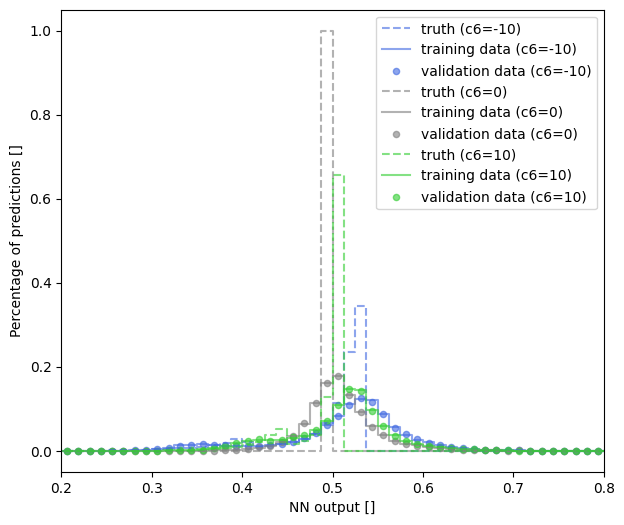

In [ ]:
BINS = 80

c6_vals = [-10,0,10]
colors = ['royalblue','gray','limegreen']

histograms, bins = generate_histograms(c6_vals, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, BINS)

plot_histograms(c6_vals, histograms, bins, colors, xlim=(0.2,0.8))

In [119]:
def generate_histograms(c6_values, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, num_bins):
    histograms = []
    for c6 in c6_values:
        r = data_train_per_c6[c6][:,-2]/data_train_per_c6[c6][:,-1]

        hist_train = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_train.fill(tf.squeeze(pred_train_per_c6[c6], axis=1))

        hist_val = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_val.fill(tf.squeeze(pred_val_per_c6[c6], axis=1))

        hist_true = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_true.fill(r/(1+r))

        histograms.append((hist_train.to_numpy(), hist_val.to_numpy(), hist_true.to_numpy()))
    
    return histograms

In [122]:
def plot_histograms(c6_values, histograms, bins, colors, xlim=(0.2,0.8)):
    fig = plt.figure(figsize=(7,6))

    for i in range(len(c6_values)):
        plt.step(histograms[i][2][1][1:], histograms[i][2][0], color=colors[i], linestyle='--', label=f'truth (c6={c6_values[i]})', alpha=0.6)
        plt.step(histograms[i][0][1][1:], histograms[i][0][0], color=colors[i], label=f'training data (c6={c6_values[i]})', alpha=0.6)
        plt.scatter(histograms[i][1][1][1:], histograms[i][1][0], s=20, color=colors[i], label=f'validation data (c6={c6_values[i]})', alpha=0.6)

    plt.xlabel('NN output []')
    plt.ylabel('Percentage of predictions []')
    plt.legend()
    #plt.xlim(xlim[0],xlim[1])

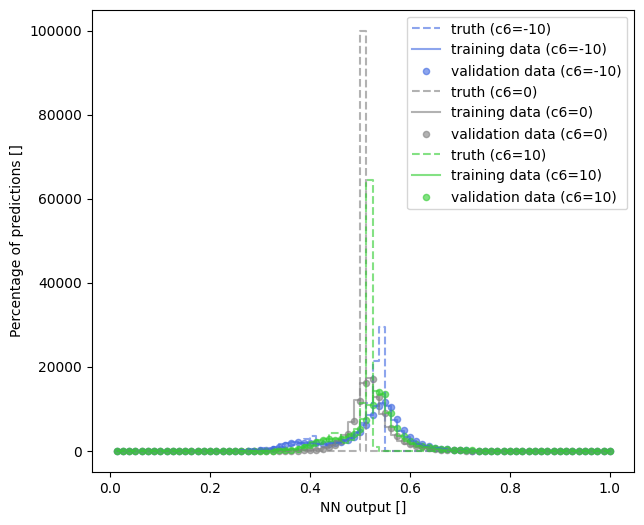

In [123]:
BINS = 80

c6_vals = [-10,0,10]
colors = ['royalblue', 'gray', 'limegreen']

histograms = generate_histograms(c6_vals, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, BINS)

plot_histograms(c6_vals, histograms, bins, colors)
plt.show()